# Package imports

In [1]:
import numpy as np
from skimage.transform import resize
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Layer, InputSpec
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize


import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%run ../src/layers/dropblock.py
%run ../src/layers/extra_layers.py
%run ../src/layers/convgru.py

Using TensorFlow backend.


# Util functions

In [2]:
def make_input_data(idx, cropping = True):
    out = np.load(f"../data/supres/numpy/{idx}_05m.npy")
    out = out.swapaxes(1, 3)
    out = out.swapaxes(1, 2)
    out = out / 10000
    inp = np.load(f"../data/supres/numpy/{idx}_10m.npy")
    inp = inp.swapaxes(1, 3)
    inp = inp.swapaxes(1, 2)
    inp = inp / 10000
    inp = resize(inp, (inp.shape[0], 256, 256, 4), 1)
    
    if cropping:
        start_x = np.random.randint(0, 256 - 128, 1)[0]
        start_y = np.random.randint(0, 256 - 128, 1)[0]
        out = out[:, start_x:start_x+128, start_y:start_y + 128]
        inp = inp[:, start_x:start_x+128, start_y:start_y + 128]

    return np.float32(inp), np.float32(out)


# Write train data

In [3]:
def to_int16(array: np.array) -> np.array:
    '''Converts a float32 array to int16, reducing storage costs by three-fold'''
    return np.trunc(np.clip(array, 0, 1) * 65535).astype(np.uint16)


paths = ['data/test/raw/', 'data/test/supres-bilinear', 'data/test/supres-input',
        'data/test/supres-label/']
for path in paths:
     if not os.path.exists(os.path.realpath(path)):
        os.makedirs(os.path.realpath(path))

# Layer functions

## PAN

In [ ]:
def pa(inp, scope):
    y = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=scope + "_conv")(inp)
    return tf.multiiply(y, inp)

def paconv(inp, scope):
    y = Conv2D(16, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
          activation='sigmoid', strides=(1, 1),
          name=scope + "_conv")(inp)
    out = Conv2D(16, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
          activation='linear', strides=(1, 1),
          name=scope + "_conv1")(inp)
    out = tf.multiply(y, out)
    out = Conv2D(16, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
          activation='linear', strides=(1, 1),
          name=scope + "_conv2")(out)
    return out



In [ ]:
class PAConv(nn.Module):

    def __init__(self, nf, k_size=3):

        super(PAConv, self).__init__()
        self.k2 = nn.Conv2d(nf, nf, 1) # 1x1 convolution nf->nf
        self.sigmoid = nn.Sigmoid()
        self.k3 = nn.Conv2d(nf, nf, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) # 3x3 convolution
        self.k4 = nn.Conv2d(nf, nf, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) # 3x3 convolution

    def forward(self, x):

        y = self.k2(x)
        y = self.sigmoid(y)

        out = torch.mul(self.k3(x), y)
        out = self.k4(out)

        return out

In [4]:
def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv



def conv_relu(inp, 
                 is_training, 
                 scope,
                 kernel_size,
                 filters, 
                 stride = (1, 1),
                 activation = True,
                 use_bias = True):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.
          
    '''

    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_uniform())(inp)
    if activation:
        conv = tf.nn.relu(conv)
    return conv

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [5]:
def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None,
                 block_size = 5,
                 padding = "VALID",
                 partial = False):
    '''2D convolution, group normalization, SWISH activation, drop block, SSE. 
       DropBlock performs best when applied last, according to original paper.
       This is the core CONV block for this model.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          keep_rate (float): Keep rate for dropblock
          stride (tuple): Conv2D stride parameter
          activation (bool): Whether or not to apply Swish activation
          use_bias (bool): whether to use bias. Should always be false
          norm (bool): whether or not to apply group normalization
          dropblock (bool): whether or not to apply dropblock
          csse (bool): whether or not to apply SSE block
          weight_decay (bool): not currently implemented
          block_size (int): Block size for dropblock
          padding (str): padding parameter for conv2d
          partial (bool): Whether or not to use partial conv or Conv2D

         Returns:
          conv (tf.Variable): output of the block
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    gn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    sse_flag = "SSE" if csse else "No SSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    print(f"{scope} Conv: Kernel: {kernel_size}, {gn_flag}, {activation_flag}, {sse_flag}, {drop_flag}")

    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, 
                      kernel_size = (kernel_size, kernel_size), 
                      strides = stride,
                      activation = None,
                      padding = 'valid',
                      use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_normal()
                     )(inp)
       
    
    if norm:
        conv = group_norm(x = conv, scope = scope, G = 4)
    if activation:
        conv = tf.nn.relu(conv)
    if csse:
        conv = sse_block(conv, "csse_" + scope)
    return conv


def resblock2(inp, is_training, scope, filters):
    inp_pad = ReflectionPadding2D()(inp)
    conv = conv_swish_gn(inp = inp_pad, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = scope + "1", filters = filters,
            keep_rate = 1., activation = True, use_bias = True, norm = False,
            csse = True, dropblock = False, weight_decay = None)
    conv_pad = ReflectionPadding2D()(conv)
    conv2 =  conv_swish_gn(inp = conv_pad, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = scope + "2", filters = filters,
            keep_rate = 1., activation = False, use_bias = True, norm = False,
            csse = True, dropblock = False, weight_decay = None)
    conv2 = tf.multiply(conv2, 0.1)
    add = tf.add(inp, conv2)
    #add = tf.nn.relu(add)
    return add
    

# Graph creation

In [6]:
inp = tf.placeholder(tf.float32, shape=(None, 128, 128, 4))
bilinear_input = tf.placeholder(tf.float32, shape = (None, 128, 128, 4))
labels =  tf.placeholder(tf.float32, shape = (None, 128, 128, 4))
is_training = tf.placeholder_with_default(False, (), 'is_training')

## Hyperparameter selection

In [7]:
depth = [2, 3, 4, 5, 6]
width = [32, 48, 64, 80, 96]

depth = 4
width = 32

In [8]:
inp_pad = ReflectionPadding2D()(inp)
conv = conv_relu(inp_pad, is_training, "in", 3, width, activation = True)

for d in range(depth):
    conv = resblock2(conv, is_training, str(d), width)
    print(d, conv.shape)
    
conv = ReflectionPadding2D()(conv)
outconv = conv_relu(conv, is_training, "out", 3, 4, activation = False)
#outconv = tf.nn.tanh(outconv)
skipconnect = tf.add(bilinear_input, outconv)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
01 Conv: Kernel: 3, , RELU, SSE, NoDrop
02 Conv: Kernel: 3, , Linear, SSE, NoDrop
0 (?, 128, 128, 32)
11 Conv: Kernel: 3, , RELU, SSE, NoDrop
12 Conv: Kernel: 3, , Linear, SSE, NoDrop
1 (?, 128, 128, 32)
21 Conv: Kernel: 3, , RELU, SSE, NoDrop
22 Conv: Kernel: 3, , Linear, SSE, NoDrop
2 (?, 128, 128, 32)
31 Conv: Kernel: 3, , RELU, SSE, NoDrop
32 Conv: Kernel: 3, , Linear, SSE, NoDrop
3 (?, 128, 128, 32)


In [9]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 76588 parameters


In [10]:
model_dir = f"models/supres/depth-{str(depth)}-width-{str(width)}-param-{str(total_parameters)}-concat-40mswir/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
print(f"The model directory is {model_dir}")

The model directory is models/supres/depth-4-width-32-param-76588-concat-40mswir/


# Training

In [11]:
optimizer = tf.train.AdamOptimizer(1e-3)
loss_fn = tf.keras.losses.MAE(labels, skipconnect)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss_fn)   
        

init_op = tf.global_variables_initializer()
sess.run(init_op)
saver = tf.train.Saver(max_to_keep = 150)
print("The graph has been finalized")

The graph has been finalized


In [12]:
# This cell should be run to do fine-tuning, if commented - train from scratch
#path = f"{model_dir}198-49.7/"
#saver.restore(sess, tf.train.latest_checkpoint(path))
#rmse = evaluate()
#print(rmse)

In [716]:
from tqdm import tnrange, tqdm_notebook
import random
losses = []
batches = ['31TCJ_2018-05-21', '31TCJ_2018-03-02', '31TCJ_2018-06-20',
                 '31TCJ_2018-09-08', '31TCJ_2018-12-07', '31TCJ_2018-12-27',
                 '21NZG_2020-08-22', '21NZG_2019-09-27', '21NZF_2020-09-11',
                 '21NZF_2020-09-11', '21MTT_2019-07-27', '21MTT_2019-12-04',
          '21MTT_2020-07-21', '31TCH_2020-03-01', '31TCH_2020-09-17',
          '31TCH_2020-01-01', '31TCH_2019-07-05',]
print(batches)

for i in range(26, 100):
    np.random.shuffle(batches)
    l = 0
    for batch in batches:
        input_, output_ = make_input_data(batch)
        print(l, '/', len(batches))
        batch_size = 8
        for k in range(input_.shape[0] // batch_size):
            opt, tr = sess.run([train_op, loss_fn],
                              feed_dict={inp: input_[k:k+batch_size],
                                         bilinear_input: input_[k:k+batch_size],
                                         labels: output_[k:k+batch_size],
                                         is_training: True,
                                         })
            losses.append(np.mean(tr))
        l += 1
    print(i, np.mean(tr))
    #rmse = evaluate()
    #print(rmse)
    #rmses[i, :] = rmse
    #if np.mean(rmse) < best_rmse:
    #    best_rmse = np.mean(rmse)
    #    os.mkdir(f"{model_dir}/{str(i)}-{str(best_rmse)[:4]}")
    #    save_path = saver.save(sess, f"{model_dir}/{str(i)}-{str(best_rmse)[:4]}/model")
    #np.save(model_dir + "metrics.npy", rmses)
    

['31TCJ_2018-05-21', '31TCJ_2018-03-02', '31TCJ_2018-06-20', '31TCJ_2018-09-08', '31TCJ_2018-12-07', '31TCJ_2018-12-27', '21NZG_2020-08-22', '21NZG_2019-09-27', '21NZF_2020-09-11', '21NZF_2020-09-11', '21MTT_2019-07-27', '21MTT_2019-12-04', '21MTT_2020-07-21', '31TCH_2020-03-01', '31TCH_2020-09-17', '31TCH_2020-01-01', '31TCH_2019-07-05']
0 / 17
1 / 17
2 / 17
3 / 17
4 / 17
5 / 17
6 / 17
7 / 17
8 / 17
9 / 17
10 / 17
11 / 17
12 / 17
13 / 17
14 / 17
15 / 17
16 / 17
26 0.0068769483
0 / 17
1 / 17
2 / 17
3 / 17
4 / 17
5 / 17
6 / 17
7 / 17
8 / 17
9 / 17
10 / 17
11 / 17
12 / 17
13 / 17
14 / 17
15 / 17
16 / 17
27 0.0057429904
0 / 17
1 / 17
2 / 17
3 / 17
4 / 17
5 / 17
6 / 17
7 / 17
8 / 17
9 / 17
10 / 17
11 / 17
12 / 17
13 / 17
14 / 17
15 / 17
16 / 17
28 0.009564638
0 / 17
1 / 17
2 / 17
3 / 17
4 / 17
5 / 17
6 / 17
7 / 17
8 / 17
9 / 17
10 / 17
11 / 17
12 / 17
13 / 17
14 / 17
15 / 17
16 / 17
29 0.0061543467
0 / 17
1 / 17
2 / 17
3 / 17
4 / 17
5 / 17
6 / 17
7 / 17
8 / 17
9 / 17
10 / 17
11 / 17
12 / 1

KeyboardInterrupt: 

# Evaluation

In [756]:
input_, output_ = make_input_data('31TCJ_2020-08-08')  # '31TCJ_2020-08-08'

idx = 6

y = sess.run([skipconnect], feed_dict={inp: input_[idx][np.newaxis],
                                       bilinear_input: input_[idx][np.newaxis], 
                                       labels: output_[idx][np.newaxis], is_training: False, })

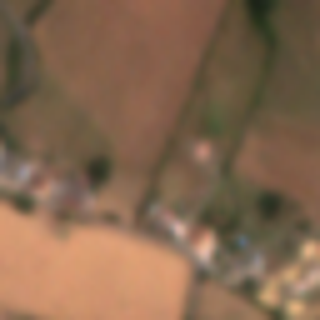

<Figure size 720x540 with 0 Axes>

In [757]:
%matplotlib inline
plt.figure(figsize=(10,7.5))
from PIL import Image
from IPython.display import display


def arr_to_rgb(arr, maxes, m = True):
    l = np.copy(arr)
    l_red = np.copy(l[..., 2])
    l_blue = np.copy(l[..., 0])
    l[..., 0] = l_red
    l[..., 2] = l_blue
    if m == True:
        maxes = np.array(np.max(l, axis = (0, 1)))
    l = l / maxes
    l = l [:64, :64]
    l = Image.fromarray((l * 255).astype(np.uint8), 'RGB')
    return l, maxes

l, m = arr_to_rgb(output_[idx, ..., :3], None, True)
display(l.resize(( int(l.width * 5), int(l.height * 5))))

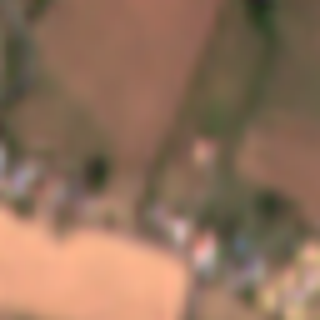

In [758]:
l, i = arr_to_rgb(y[0][0, ..., :3], None, True)
display(l.resize(( int(l.width * 5), int(l.height * 5))))

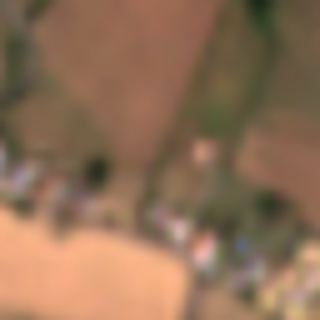

In [759]:
l, i = arr_to_rgb(input_[idx, ..., :3], None, True)
display(l.resize(( int(l.width * 5), int(l.height * 5))))

In [711]:
def evaluate():
    test_ids = [x for x in os.listdir("data/test/supres-label") if ".npy" in x]
    n_batches = len(test_ids) // 5
    rmses = np.empty((n_batches, 6))
    for batch in range(0, len(test_ids) // 5):
        batch_ids = test_ids[batch*5: (batch+1) *5]
        bilinear_upsample, input_data, labels_ = load_batch(batch_ids, "test", 5)
        input_data[..., 4:] = bilinear_upsample
        y = sess.run([skipconnect], feed_dict={inp: input_data,
                                         bilinear_input: bilinear_upsample,
                                         labels: labels_,
                                         is_training: True,
                                         })
        y = np.concatenate(y)
        se = (labels_*10000 - y*10000)**2
        mse = np.mean(se, axis = (0, 1, 2))
        mse = np.clip(mse, 0, np.max(mse))
        if np.max(mse) > 25000:
            print(np.max(mse), batch_ids)
        rmse = np.sqrt(mse)
        #rmse = np.clip(rmse, 0, 1)
        rmses[batch] = rmse
    rmses = np.mean(rmses, 0)
    return rmses

def evaluate_bilinear():
    test_ids = [x for x in os.listdir("data/test/supres-label/") if ".npy" in x]
    n_batches = len(test_ids) // 5
    rmses = np.empty((n_batches, 6))
    for batch in range(len(test_ids) // 5):
        batch_ids = test_ids[batch*5: (batch+1) *5]
        bilinear_upsample, input_data, labels_ = load_batch(batch_ids, "test", 5)
        se = (labels_*10000 - bilinear_upsample*10000)**2
        mse = np.mean(se, axis = (0, 1, 2))
        rmse = np.sqrt(mse)
        rmses[batch] = rmse
    rmses = np.mean(rmses, 0)
    print(rmses)
    return rmses

def make_test_data(data):
    input_data = data
    twentym = np.copy(data[..., 4:])
    twentym = np.reshape(twentym, ((twentym.shape[0], 24, 2, 24, 2, 6)))
    twentym = np.mean(twentym, axis = (2, 4))
    bilinear_upsample = resize(twentym, (twentym.shape[0], 48, 48, 6), 1)
    
    fourtym = np.copy(data[..., -2:])
    fourtym = np.reshape(fourtym, ((twentym.shape[0], 12, 4, 12, 4, 2)))
    fourtym = np.mean(fourtym, axis = (2, 4))
    fourtym = resize(fourtym, (fourtym.shape[0], 48, 48, 2), 1)
    
    bilinear_upsample[..., -2:] = fourtym
                     
    return bilinear_upsample, input_data